In [1]:
from google.colab import drive
drive.mount("/content/drive")

!pip -q install timm pandas scikit-learn tqdm


Mounted at /content/drive


In [2]:
from pathlib import Path
import json
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from PIL import Image

import timm
from tqdm import tqdm

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt


In [3]:
PROJECT_ROOT = Path("/content/drive/MyDrive/SkinCare_AI_Component")

META_DIR = PROJECT_ROOT / "data/12_skin_concerns/metadata"
INDEX_CSV = META_DIR / "image_index_skin_concerns.csv"
LABEL_MAP_JSON = META_DIR / "label_map_skin_concerns.json"

assert INDEX_CSV.exists(), f"❌ Missing: {INDEX_CSV}"
assert LABEL_MAP_JSON.exists(), f"❌ Missing: {LABEL_MAP_JSON}"

df = pd.read_csv(INDEX_CSV)

with open(LABEL_MAP_JSON, "r") as f:
    label_map = json.load(f)

id_to_label = {v: k for k, v in label_map.items()}
num_classes = len(label_map)

print("✅ Rows:", len(df))
print("✅ Classes:", label_map)

df_train = df[df["split"] == "train"].reset_index(drop=True)
df_val   = df[df["split"] == "val"].reset_index(drop=True)
df_test  = df[df["split"] == "test"].reset_index(drop=True)

print("Train:", len(df_train), "Val:", len(df_val), "Test:", len(df_test))
df_train.head()


✅ Rows: 13209
✅ Classes: {'acne_pimples': 0, 'redness_irritation': 1, 'dark_spots_uneven_tone': 2, 'dryness_flaking': 3, 'normal_clear': 4}
Train: 9242 Val: 1979 Test: 1988


,image_path,label_name,label_id,split
0,data/12_skin_concerns/curated/acne_pimples/acn...,acne_pimples,0,train
1,data/12_skin_concerns/curated/acne_pimples/acn...,acne_pimples,0,train
2,data/12_skin_concerns/curated/acne_pimples/acn...,acne_pimples,0,train
3,data/12_skin_concerns/curated/acne_pimples/acn...,acne_pimples,0,train
4,data/12_skin_concerns/curated/acne_pimples/acn...,acne_pimples,0,train


In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

MODEL_NAME = "convnext_tiny"
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 12
LR = 3e-4
WEIGHT_DECAY = 1e-4
NUM_WORKERS = 2

# Mixed precision
USE_AMP = True

# Save path
MODEL_DIR = PROJECT_ROOT / "models/vision"
MODEL_DIR.mkdir(parents=True, exist_ok=True)
BEST_CKPT = MODEL_DIR / "skin_concerns_convnext_best.pt"
print("Best ckpt:", BEST_CKPT)


Device: cuda
Best ckpt: /content/drive/MyDrive/SkinCare_AI_Component/models/vision/skin_concerns_convnext_best.pt


In [5]:
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.10, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

class ConcernDS(Dataset):
    def __init__(self, df_, tfm):
        self.df = df_.reset_index(drop=True)
        self.tfm = tfm

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        img_path = PROJECT_ROOT / r["image_path"]
        img = Image.open(img_path).convert("RGB")
        x = self.tfm(img)
        y = int(r["label_id"])
        return x, y

train_loader = DataLoader(
    ConcernDS(df_train, train_tfms),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    ConcernDS(df_val, eval_tfms),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    ConcernDS(df_test, eval_tfms),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print("✅ Loaders ready.")


✅ Loaders ready.


In [6]:
model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=num_classes)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

scaler = torch.cuda.amp.GradScaler(enabled=(USE_AMP and DEVICE.type == "cuda"))

print("✅ Model ready:", MODEL_NAME)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

✅ Model ready: convnext_tiny


/tmp/ipython-input-638719953.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(USE_AMP and DEVICE.type == "cuda"))


In [7]:
def run_eval(loader):
    model.eval()
    all_y, all_p = [], []
    total_loss = 0.0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            logits = model(x)
            loss = criterion(logits, y)

            total_loss += loss.item() * x.size(0)

            pred = logits.argmax(dim=1)
            all_y.extend(y.cpu().numpy().tolist())
            all_p.extend(pred.cpu().numpy().tolist())

    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(all_y, all_p)
    f1 = f1_score(all_y, all_p, average="macro")
    return avg_loss, acc, f1


best_val_acc = -1.0

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    all_y, all_p = [], []

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}"):
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=(USE_AMP and DEVICE.type == "cuda")):
            logits = model(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * x.size(0)

        pred = logits.argmax(dim=1)
        all_y.extend(y.cpu().numpy().tolist())
        all_p.extend(pred.detach().cpu().numpy().tolist())

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = accuracy_score(all_y, all_p)
    train_f1 = f1_score(all_y, all_p, average="macro")

    val_loss, val_acc, val_f1 = run_eval(val_loader)

    print(f"\nEpoch {epoch}/{EPOCHS}")
    print(f"Train loss {train_loss:.4f} | acc {train_acc:.4f} | macroF1 {train_f1:.4f}")
    print(f"Val   loss {val_loss:.4f} | acc {val_acc:.4f} | macroF1 {val_f1:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc

        torch.save({
            "model_name": MODEL_NAME,
            "model_state": model.state_dict(),
            "label_map": label_map,
            "img_size": IMG_SIZE,
        }, BEST_CKPT)

        print("✅ Saved best:", BEST_CKPT)

print("\n🏁 Training finished. Best val acc:", best_val_acc)


Epoch 1/12:   0%|          | 0/289 [00:00<?, ?it/s]/tmp/ipython-input-131689498.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(USE_AMP and DEVICE.type == "cuda")):
Epoch 1/12: 100%|██████████| 289/289 [21:04<00:00,  4.38s/it]



Epoch 1/12
Train loss 1.3526 | acc 0.4600 | macroF1 0.2307
Val   loss 1.1261 | acc 0.5382 | macroF1 0.2852
✅ Saved best: /content/drive/MyDrive/SkinCare_AI_Component/models/vision/skin_concerns_convnext_best.pt


Epoch 2/12:   0%|          | 0/289 [00:00<?, ?it/s]/tmp/ipython-input-131689498.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(USE_AMP and DEVICE.type == "cuda")):
Epoch 2/12: 100%|██████████| 289/289 [02:18<00:00,  2.08it/s]



Epoch 2/12
Train loss 1.0572 | acc 0.5469 | macroF1 0.3541
Val   loss 0.9929 | acc 0.5836 | macroF1 0.3138
✅ Saved best: /content/drive/MyDrive/SkinCare_AI_Component/models/vision/skin_concerns_convnext_best.pt


Epoch 3/12:   0%|          | 0/289 [00:00<?, ?it/s]/tmp/ipython-input-131689498.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(USE_AMP and DEVICE.type == "cuda")):
Epoch 3/12: 100%|██████████| 289/289 [02:18<00:00,  2.09it/s]



Epoch 3/12
Train loss 0.9040 | acc 0.6180 | macroF1 0.4602
Val   loss 0.9032 | acc 0.6210 | macroF1 0.5522
✅ Saved best: /content/drive/MyDrive/SkinCare_AI_Component/models/vision/skin_concerns_convnext_best.pt


Epoch 4/12:   0%|          | 0/289 [00:00<?, ?it/s]/tmp/ipython-input-131689498.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(USE_AMP and DEVICE.type == "cuda")):
Epoch 4/12: 100%|██████████| 289/289 [02:18<00:00,  2.08it/s]



Epoch 4/12
Train loss 0.7524 | acc 0.6918 | macroF1 0.5936
Val   loss 0.7688 | acc 0.6862 | macroF1 0.5662
✅ Saved best: /content/drive/MyDrive/SkinCare_AI_Component/models/vision/skin_concerns_convnext_best.pt


Epoch 5/12:   0%|          | 0/289 [00:00<?, ?it/s]/tmp/ipython-input-131689498.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(USE_AMP and DEVICE.type == "cuda")):
Epoch 5/12: 100%|██████████| 289/289 [02:18<00:00,  2.08it/s]



Epoch 5/12
Train loss 0.6670 | acc 0.7270 | macroF1 0.6597
Val   loss 0.6782 | acc 0.7196 | macroF1 0.6610
✅ Saved best: /content/drive/MyDrive/SkinCare_AI_Component/models/vision/skin_concerns_convnext_best.pt


Epoch 6/12:   0%|          | 0/289 [00:00<?, ?it/s]/tmp/ipython-input-131689498.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(USE_AMP and DEVICE.type == "cuda")):
Epoch 6/12: 100%|██████████| 289/289 [02:17<00:00,  2.10it/s]



Epoch 6/12
Train loss 0.5594 | acc 0.7781 | macroF1 0.7173
Val   loss 0.5608 | acc 0.7827 | macroF1 0.7286
✅ Saved best: /content/drive/MyDrive/SkinCare_AI_Component/models/vision/skin_concerns_convnext_best.pt


Epoch 7/12:   0%|          | 0/289 [00:00<?, ?it/s]/tmp/ipython-input-131689498.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(USE_AMP and DEVICE.type == "cuda")):
Epoch 7/12: 100%|██████████| 289/289 [02:18<00:00,  2.08it/s]



Epoch 7/12
Train loss 0.4922 | acc 0.8136 | macroF1 0.7644
Val   loss 0.5557 | acc 0.7852 | macroF1 0.7418
✅ Saved best: /content/drive/MyDrive/SkinCare_AI_Component/models/vision/skin_concerns_convnext_best.pt


Epoch 8/12:   0%|          | 0/289 [00:00<?, ?it/s]/tmp/ipython-input-131689498.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(USE_AMP and DEVICE.type == "cuda")):
Epoch 8/12: 100%|██████████| 289/289 [02:18<00:00,  2.08it/s]



Epoch 8/12
Train loss 0.4279 | acc 0.8356 | macroF1 0.7910
Val   loss 0.4827 | acc 0.8201 | macroF1 0.7693
✅ Saved best: /content/drive/MyDrive/SkinCare_AI_Component/models/vision/skin_concerns_convnext_best.pt


Epoch 9/12:   0%|          | 0/289 [00:00<?, ?it/s]/tmp/ipython-input-131689498.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(USE_AMP and DEVICE.type == "cuda")):
Epoch 9/12: 100%|██████████| 289/289 [02:18<00:00,  2.08it/s]



Epoch 9/12
Train loss 0.3703 | acc 0.8584 | macroF1 0.8161
Val   loss 0.4844 | acc 0.8146 | macroF1 0.7652


Epoch 10/12:   0%|          | 0/289 [00:00<?, ?it/s]/tmp/ipython-input-131689498.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(USE_AMP and DEVICE.type == "cuda")):
Epoch 10/12: 100%|██████████| 289/289 [02:15<00:00,  2.13it/s]



Epoch 10/12
Train loss 0.3125 | acc 0.8833 | macroF1 0.8473
Val   loss 0.3650 | acc 0.8747 | macroF1 0.8301
✅ Saved best: /content/drive/MyDrive/SkinCare_AI_Component/models/vision/skin_concerns_convnext_best.pt


Epoch 11/12:   0%|          | 0/289 [00:00<?, ?it/s]/tmp/ipython-input-131689498.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(USE_AMP and DEVICE.type == "cuda")):
Epoch 11/12: 100%|██████████| 289/289 [02:17<00:00,  2.10it/s]



Epoch 11/12
Train loss 0.2747 | acc 0.8967 | macroF1 0.8629
Val   loss 0.3836 | acc 0.8615 | macroF1 0.8106


Epoch 12/12:   0%|          | 0/289 [00:00<?, ?it/s]/tmp/ipython-input-131689498.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(USE_AMP and DEVICE.type == "cuda")):
Epoch 12/12: 100%|██████████| 289/289 [02:14<00:00,  2.14it/s]



Epoch 12/12
Train loss 0.2372 | acc 0.9125 | macroF1 0.8857
Val   loss 0.3887 | acc 0.8626 | macroF1 0.8176

🏁 Training finished. Best val acc: 0.8746841839312784


In [8]:
# Load best checkpoint
ckpt = torch.load(BEST_CKPT, map_location=DEVICE)
model.load_state_dict(ckpt["model_state"])
model.eval()

all_y, all_p = [], []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Testing"):
        x = x.to(DEVICE)
        logits = model(x)
        pred = logits.argmax(dim=1).cpu().numpy().tolist()

        all_y.extend(y.numpy().tolist())
        all_p.extend(pred)

test_acc = accuracy_score(all_y, all_p)
test_f1  = f1_score(all_y, all_p, average="macro")

print("\n✅ TEST RESULTS")
print("Test Accuracy:", test_acc)
print("Macro F1:", test_f1)

labels_sorted = [id_to_label[i] for i in range(num_classes)]
print("\nClassification Report:")
print(classification_report(all_y, all_p, target_names=labels_sorted))


Testing: 100%|██████████| 63/63 [04:26<00:00,  4.23s/it]


✅ TEST RESULTS
Test Accuracy: 0.8621730382293763
Macro F1: 0.8013724847298311

Classification Report:
                        precision    recall  f1-score   support

          acne_pimples       0.84      0.82      0.83       454
    redness_irritation       0.86      0.92      0.89       882
dark_spots_uneven_tone       0.74      0.79      0.77       160
       dryness_flaking       0.93      0.44      0.60        95
          normal_clear       0.93      0.91      0.92       397

              accuracy                           0.86      1988
             macro avg       0.86      0.78      0.80      1988
          weighted avg       0.86      0.86      0.86      1988



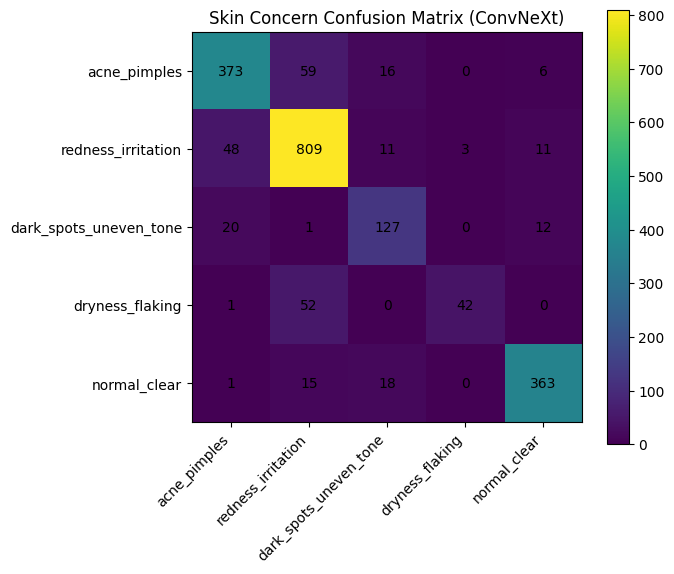

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_y, all_p, labels=list(range(num_classes)))
labels_sorted = [id_to_label[i] for i in range(num_classes)]

plt.figure(figsize=(7,6))
plt.imshow(cm)
plt.title("Skin Concern Confusion Matrix (ConvNeXt)")
plt.xticks(range(num_classes), labels_sorted, rotation=45, ha="right")
plt.yticks(range(num_classes), labels_sorted)

# ✅ draw numbers inside
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")

plt.colorbar()
plt.tight_layout()
plt.show()


In [10]:
OUT_RES = PROJECT_ROOT / "results/skin_concerns"
OUT_RES.mkdir(parents=True, exist_ok=True)

metrics_path = OUT_RES / "skin_concerns_test_metrics.json"

metrics = {
    "model_name": MODEL_NAME,
    "num_classes": num_classes,
    "test_accuracy": float(test_acc),
    "test_macro_f1": float(test_f1),
    "labels": labels_sorted
}

with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=2)

print("✅ Saved metrics:", metrics_path)


✅ Saved metrics: /content/drive/MyDrive/SkinCare_AI_Component/results/skin_concerns/skin_concerns_test_metrics.json
